# Predicting High Fire Risk Areas in Montreal

## Summary:
**Dataset:** The dataset is a list of building fire incidents in the city of Montreal spanning from Jan 2015 to Sept 2022. Includes features relating to the  incident and to the corresponding census tract area, aggregated from multiple sources.  
**Model:** Classifies the census tract areas (out of 540) which are deemed high fire risk, as a prediction for the following month. Random Forest model and Logistic Regression model developed, with a baseline model for comparison.  
**Particulars:** Hyperparameter tuning, feature selection mechanism, imbalanced dataset, time lags, ROC curves

## Table of Contents:
* Section 1 - Data Preparation
* Section 2 - Generating non-ML Baseline Model
* Section 3 - Feature Engineering
* Section 4 - Data Pre-processing
* Section 5 - Preliminary Feature Ranking
* Section 6 - Feature Selection and Hyperparamater Tuning
* Section 7 - Final Models and Results

In [2]:
import math
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.exceptions import FitFailedWarning
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, balanced_accuracy_score

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
# Importing dataset: List of  fire incidents in Montreal (Jan 2015 to Sept 2022) with incident and census tract area details

pd.options.display.max_columns = None
pd.options.display.max_rows = 8

df = pd.read_csv('FireIncidents_w_Attributes.csv')
df.head(5)

,Fire_IncidentNo,Fire_DateTime,Fire_Type,Fire_Group,Fire_Ville,Fire_Arrond,Longitude,Latitude,CT_DGUID,CT_LandArea(sqkm),A_Count_Coundo,A_Count_Regulier,A_Count_Other,A_AvgYear_Condo,A_AvgYear_Regulier,A_AvgYear_Other,A_SumArea(sqm)_Condo,A_SumArea(sqm)_Regulier,A_SumArea(sqm)_Other,B_PopDensity(sqkm),C_%HousesNeedingMajorRepair,D_%Homeownership,E_%Population65+,F_AvgAge,G_AvgHomeValue,H_MedianIncome
0,8328,2015-01-21 15:31:05,Feu / 4e Alerte,INCENDIE,Montréal,Côte-des-Neiges-Notre-Dame-de-Grâce,-73.627703,45.506320,2021S05074620123.00,0.4104,196,277,31,1957.734694,1948.700361,1961.615385,12538,195476,86068,15789.5,8.2,8.1,11.1,35.7,600000,29800
1,11888,2015-02-01 12:20:13,10-22 avec feu,INCENDIE,Montréal,Saint-Laurent,-73.727380,45.496187,2021S05074620415.09,9.8046,568,396,825,2003.896127,2000.398990,1986.680060,91317,156838,8357786,309.3,3.4,78.7,8.2,36.1,818000,53600
2,13353,2015-02-05 07:20:29,Feu / Agravation possible,INCENDIE,Montréal,Le Sud-Ouest,-73.599686,45.448475,2021S05074620090.00,0.4356,197,778,19,1986.850575,1951.252252,1950.375000,15638,239389,27059,10534.9,10.3,34.6,16.3,40.8,574000,33600
3,14728,2015-02-09 00:58:47,Feu / Agravation possible,INCENDIE,Montréal,L'Île-Bizard-Sainte-Geneviève,-73.874695,45.518268,2021S05074620550.03,4.9277,12,2168,203,1997.500000,1988.113573,1974.227273,2820,2014197,3494718,1375.9,3.9,91.1,16.6,42.0,647000,48000
4,35812,2015-04-12 18:12:42,Feu de bâtiment,INCENDIE,Montréal,Rivière-des-Prairies-Pointe-aux-Trembles,-73.501102,45.675332,2021S05074620580.01,1.1690,640,791,100,2003.243711,1969.930380,1975.750000,90927,359031,549017,4151.4,4.1,52.1,18.4,43.0,337000,41200


# Section 1 - Data Preparation

In [4]:
# Dropping unnecessary/non-predictive attribute columns
df_init = df.drop(df.columns[[0,2,3,4,5,6,7]], axis=1)

# Converting incident timestamp to python type 'datetime'
df_init['Fire_DateTime'] = pd.to_datetime(df_init['Fire_DateTime'])

# Replacing null values with column averages
df_init['A_AvgYear_Condo'] = df_init['A_AvgYear_Condo'].fillna(0)
df_init['A_AvgYear_Regulier'] = df_init['A_AvgYear_Regulier'].fillna(0)
df_init['A_AvgYear_Other'] = df_init['A_AvgYear_Other'].fillna(0)

df_init['A_AvgYear_Condo'] = df_init['A_AvgYear_Condo'].replace(to_replace = 0, value = df_init[df_init['A_AvgYear_Condo'] != 0]["A_AvgYear_Condo"].mean(), inplace=False)
df_init['A_AvgYear_Regulier'] = df_init['A_AvgYear_Regulier'].replace(to_replace = 0, value = df_init[df_init['A_AvgYear_Regulier'] != 0]["A_AvgYear_Regulier"].mean(), inplace=False)
df_init['A_AvgYear_Other'] = df_init['A_AvgYear_Other'].replace(to_replace = 0, value = df_init[df_init['A_AvgYear_Other'] != 0]["A_AvgYear_Other"].mean(), inplace=False)

# Normalizing attributes by land area, to properly compare census tract areas of different sizes
df_init['A_Count_Coundo'] = df_init['A_Count_Coundo']/df_init['CT_LandArea(sqkm)']
df_init['A_Count_Regulier'] = df_init['A_Count_Regulier']/df_init['CT_LandArea(sqkm)']
df_init['A_Count_Other'] = df_init['A_Count_Other']/df_init['CT_LandArea(sqkm)']
df_init['A_SumArea(sqm)_Condo'] = df_init['A_SumArea(sqm)_Condo']/df_init['CT_LandArea(sqkm)']
df_init['A_SumArea(sqm)_Regulier'] = df_init['A_SumArea(sqm)_Regulier']/df_init['CT_LandArea(sqkm)']
df_init['A_SumArea(sqm)_Other'] = df_init['A_SumArea(sqm)_Other']/df_init['CT_LandArea(sqkm)']

In [5]:
df_init.head(5)

df_init['CT_DGUID'].describe()
min_date = min(df_init['Fire_DateTime'])
max_date = max(df_init['Fire_DateTime'])

print('\n')
min_date
print('\n')
max_date

,Fire_DateTime,CT_DGUID,CT_LandArea(sqkm),A_Count_Coundo,A_Count_Regulier,A_Count_Other,A_AvgYear_Condo,A_AvgYear_Regulier,A_AvgYear_Other,A_SumArea(sqm)_Condo,A_SumArea(sqm)_Regulier,A_SumArea(sqm)_Other,B_PopDensity(sqkm),C_%HousesNeedingMajorRepair,D_%Homeownership,E_%Population65+,F_AvgAge,G_AvgHomeValue,H_MedianIncome
0,2015-01-21 15:31:05,2021S05074620123.00,0.4104,477.582846,674.951267,75.536062,1957.734694,1948.700361,1961.615385,30550.682261,476306.042885,209717.348928,15789.5,8.2,8.1,11.1,35.7,600000,29800
1,2015-02-01 12:20:13,2021S05074620415.09,9.8046,57.931991,40.389205,84.144177,2003.896127,2000.398990,1986.680060,9313.689493,15996.369051,852435.183485,309.3,3.4,78.7,8.2,36.1,818000,53600
2,2015-02-05 07:20:29,2021S05074620090.00,0.4356,452.249770,1786.042241,43.617998,1986.850575,1951.252252,1950.375000,35899.908173,549561.524334,62118.916437,10534.9,10.3,34.6,16.3,40.8,574000,33600
3,2015-02-09 00:58:47,2021S05074620550.03,4.9277,2.435213,439.961848,41.195690,1997.500000,1988.113573,1974.227273,572.275098,408749.923900,709198.611928,1375.9,3.9,91.1,16.6,42.0,647000,48000
4,2015-04-12 18:12:42,2021S05074620580.01,1.1690,547.476476,676.646707,85.543199,2003.243711,1969.930380,1975.750000,77781.864842,307126.603935,469646.706587,4151.4,4.1,52.1,18.4,43.0,337000,41200


count                    9463
unique                    540
top       2021S05074620570.00
freq                       69
Name: CT_DGUID, dtype: object

Timestamp('2015-01-01 00:56:44')

Timestamp('2022-09-12 21:19:47')

# Section 2 - Generating non-ML Baseline Model
>The non-ML model predictions are based on a 5-year historical average, of the monthly fire counts per census tract area. (Data from years 2015 - 2020)



In [6]:
# Fire counts are now aggregated by census tract area and by month.

#The 'DGUID' is the census tract area identifier
DGUID_list = sorted(df_init['CT_DGUID'].unique())
t_index = pd.DatetimeIndex(pd.date_range(start='2015-01-01', end='2022-08-31', freq="M"))
df_baseline = pd.DataFrame()

for i in DGUID_list:
  #Fire count aggregated by month basis and by census tract area
  df_dguid = df_init[df_init.loc[:, 'CT_DGUID'] == i]
  df_i = pd.DataFrame()
  df_i['count'] = df_dguid.set_index('Fire_DateTime').resample('M').count().reindex(t_index).fillna(0)['CT_DGUID']

  #Normalizing fire count by sqkm area to get fire count density
  div_factor = df_dguid['CT_LandArea(sqkm)'].iloc[0]
  df_i = df_i/div_factor

  #Adding the census tract attributes to each row
  dguid_attrs = df_dguid.drop(df_init.columns[[0]], axis=1).iloc[[0]]
  dguid_attrs = pd.concat([dguid_attrs]*df_i.shape[0])
  dguid_attrs.index = df_i.index
  df_i = pd.concat([df_i,dguid_attrs], axis=1)
  df_baseline = pd.concat([df_baseline,df_i], axis=0)

df_baseline['month'] = df_baseline.index.month
df_baseline = df_baseline[['count','CT_DGUID','month']]
df_baseline['monthly_mean'] = 555

#Averaging the monthly fire desity over the 5 year period and using it as the predictions for years 2021 and 2022
for i in DGUID_list:
  for month in range(12):
    df_baseline.loc[(df_baseline.index < pd.to_datetime('2021')) & (df_baseline.CT_DGUID == i) & (df_baseline.month == month+1), ['monthly_mean']] = df_baseline.loc[(df_baseline.index < pd.to_datetime('2021')) & (df_baseline.CT_DGUID == i) & (df_baseline.month == month+1)]['count'].mean()

for i in DGUID_list:
  df_baseline.loc[(df_baseline.index < pd.to_datetime('2022')) & (df_baseline.index >= pd.to_datetime('2021')) & (df_baseline.CT_DGUID == i), ['monthly_mean']] = df_baseline.loc[(df_baseline.index < pd.to_datetime('2016')) & (df_baseline.CT_DGUID == i)]['monthly_mean'].values
  df_baseline.loc[(df_baseline.index >= pd.to_datetime('2022')) & (df_baseline.CT_DGUID == i), ['monthly_mean']] = df_baseline.loc[(df_baseline.index < pd.to_datetime('2015-09')) & (df_baseline.CT_DGUID == i)]['monthly_mean'].values

df_baseline.head(5)
print('\n')
df_baseline.loc[(df_baseline.index < pd.to_datetime('2016')) , ['monthly_mean']]['monthly_mean'].nlargest(1750)


,count,CT_DGUID,month,monthly_mean
2015-01-31,2.15378,2021S05074620001.00,1,0.358963
2015-02-28,0.00000,2021S05074620001.00,2,0.358963
2015-03-31,0.00000,2021S05074620001.00,3,0.000000
2015-04-30,0.00000,2021S05074620001.00,4,0.000000
2015-05-31,0.00000,2021S05074620001.00,5,0.000000


2015-08-31    9.090909
2015-07-31    8.984726
2015-07-31    7.204611
2015-12-31    6.087168
                ...   
2015-02-28    0.621659
2015-04-30    0.621659
2015-06-30    0.621659
2015-08-31    0.621659
Name: monthly_mean, Length: 1750, dtype: float64

In [7]:
# Generating the prediciton values as a binary high (1) or low (0) risk, using a threshold for the fire count density values

df_baseline['pred_baseline'] = 0
df_baseline.loc[(df_baseline.monthly_mean >= 0.621659) , ['pred_baseline']] = 1
df_baseline = df_baseline.loc[(df_baseline.index < pd.to_datetime('2022-08')) & (df_baseline.index >= pd.to_datetime('2015-12-31'))]

df_baseline

,count,CT_DGUID,month,monthly_mean,pred_baseline
2015-12-31,0.000000,2021S05074620001.00,12,0.358963,0
2016-01-31,0.000000,2021S05074620001.00,1,0.358963,0
2016-02-29,2.153780,2021S05074620001.00,2,0.358963,0
2016-03-31,0.000000,2021S05074620001.00,3,0.000000,0
...,...,...,...,...,...
2022-04-30,0.000000,2021S05074620619.00,4,1.138239,1
2022-05-31,1.707359,2021S05074620619.00,5,0.569120,0
2022-06-30,0.000000,2021S05074620619.00,6,0.000000,0
2022-07-31,0.000000,2021S05074620619.00,7,0.853679,1


# Section 3 - Feature Engineering
>Monthly Lag Features: Capturing the fire count densities of each of the previous 12 months

>Counter Features: Aggregating the fire count densities over the past 3 month, 6 months, and 12 months

>Trigonometric Transformation Features: Encoding incident month using trigonometic coordinates

>Polynomial Transformation Features: Generating new features using polynomial basis transformations of the existing features {(x, y): x^2, xy, y^2}

In [8]:
# Monthly Lag Features

#The 'DGUID' is the census tract area identifier
DGUID_list = sorted(df_init['CT_DGUID'].unique())
t_index = pd.DatetimeIndex(pd.date_range(start='2015-01-01', end='2022-08-31', freq="M"))
df_final = pd.DataFrame()

for i in DGUID_list:
  #Fire count aggregated by month basis and by census tract area
  df_dguid = df_init[df_init.loc[:, 'CT_DGUID'] == i]
  df_i = pd.DataFrame()
  df_i['count'] = df_dguid.set_index('Fire_DateTime').resample('M').count().reindex(t_index).fillna(0)['CT_DGUID']

  #Normalizing fire count by sqkm area to get fire count density
  div_factor = df_dguid['CT_LandArea(sqkm)'].iloc[0]
  df_i = df_i/div_factor

  #Generating 12 montly lags from the current incident date and the (future month) response variable value
  no_lags = 12
  for j in range(no_lags):
    df_i[f'lag_{j}'] = df_i['count'].shift(j)
  df_i[f'pred'] = df_i['count'].shift(-1)
  df_i = df_i.dropna()

  #Adding the census tract attributes to each row
  dguid_attrs = df_dguid.drop(df_init.columns[[0]], axis=1).iloc[[0]]
  dguid_attrs = pd.concat([dguid_attrs]*df_i.shape[0])
  dguid_attrs.index = df_i.index
  df_i = pd.concat([df_i,dguid_attrs], axis=1).drop(['count'], axis=1)
  df_final = pd.concat([df_final,df_i], axis=0)
  
df_w_DGUID = df_final.copy()
df_final = df_final.drop(['CT_DGUID'], axis=1)

In [9]:
# Counter Features and Trigonometric Transformation Features

#Aggregating the fire count densities over the past 3 month, 6 months, and 12 months
df_final['last_3months'] = df_final[['lag_0', 'lag_1','lag_2']].sum(axis=1)
df_final['last_6months'] = df_final[['lag_0', 'lag_1','lag_2', 'lag_3','lag_4', 'lag_5']].sum(axis=1)
df_final['last_12months'] = df_final[['lag_0', 'lag_1','lag_2', 'lag_3','lag_4', 'lag_5','lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11']].sum(axis=1)

season_dict = {1: 1,
               2: 1,
               3: 1, 
               4: 2,
               5: 2,
               6: 2,
               7: 3,
               8: 3,
               9: 3,
               10: 4,
               11: 4,
               12: 4}

#Encoding incident month using trigonometic coordinates
df_final['month'] = df_final.index.month
df_final['month_sin'] = df_final['month'].apply(lambda x: math.sin(2*math.pi*x/12)) 
df_final['month_cos'] = df_final['month'].apply(lambda x: math.cos(2*math.pi*x/12)) 
df_final['season'] = df_final['month'].apply(lambda x: season_dict[x])
df_final['season_sin'] = df_final['season'].apply(lambda x: math.sin(2*math.pi*x/4)) 
df_final['season_cos'] = df_final['season'].apply(lambda x: math.cos(2*math.pi*x/4)) 

df_final = df_final.drop(['month', 'season', 'CT_LandArea(sqkm)'], axis=1, errors='ignore')

df_final.head(5)

,lag_0,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,pred,A_Count_Coundo,A_Count_Regulier,A_Count_Other,A_AvgYear_Condo,A_AvgYear_Regulier,A_AvgYear_Other,A_SumArea(sqm)_Condo,A_SumArea(sqm)_Regulier,A_SumArea(sqm)_Other,B_PopDensity(sqkm),C_%HousesNeedingMajorRepair,D_%Homeownership,E_%Population65+,F_AvgAge,G_AvgHomeValue,H_MedianIncome,last_3months,last_6months,last_12months,month_sin,month_cos,season_sin,season_cos
2015-12-31,0.00000,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.15378,0.00000,626.749946,1025.199225,79.689856,2002.106529,1950.716102,1979.333333,48309.282791,268778.806806,134561.705794,5780.7,12.7,44.6,16.8,42.3,370000,40000,0.00000,0.00000,2.15378,-2.449294e-16,1.000000e+00,-2.449294e-16,1.000000e+00
2016-01-31,0.00000,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,2.15378,626.749946,1025.199225,79.689856,2002.106529,1950.716102,1979.333333,48309.282791,268778.806806,134561.705794,5780.7,12.7,44.6,16.8,42.3,370000,40000,0.00000,0.00000,0.00000,5.000000e-01,8.660254e-01,1.000000e+00,6.123234e-17
2016-02-29,2.15378,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,626.749946,1025.199225,79.689856,2002.106529,1950.716102,1979.333333,48309.282791,268778.806806,134561.705794,5780.7,12.7,44.6,16.8,42.3,370000,40000,2.15378,2.15378,2.15378,8.660254e-01,5.000000e-01,1.000000e+00,6.123234e-17
2016-03-31,0.00000,2.15378,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,626.749946,1025.199225,79.689856,2002.106529,1950.716102,1979.333333,48309.282791,268778.806806,134561.705794,5780.7,12.7,44.6,16.8,42.3,370000,40000,2.15378,2.15378,2.15378,1.000000e+00,6.123234e-17,1.000000e+00,6.123234e-17
2016-04-30,0.00000,0.00000,2.15378,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,626.749946,1025.199225,79.689856,2002.106529,1950.716102,1979.333333,48309.282791,268778.806806,134561.705794,5780.7,12.7,44.6,16.8,42.3,370000,40000,2.15378,2.15378,2.15378,8.660254e-01,-5.000000e-01,1.224647e-16,-1.000000e+00


In [10]:
# Polynomial transformations

#Generating new features using polynomial basis transformations of the existing features {(x, y): x^2, xy, y^2}
df_polyn = df_final.drop(['pred','lag_0', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11'], axis=1, errors='ignore')
Polynomial_transformer = PolynomialFeatures(degree=2, include_bias=False)
polyn_basis = Polynomial_transformer.fit_transform(df_polyn)

headers_polyn = Polynomial_transformer.get_feature_names_out(df_polyn.columns)

df_final_polyn = pd.DataFrame(polyn_basis)
df_final_polyn.index = df_final.index
df_final_polyn.columns = headers_polyn
df_final_polyn[['lag_0', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11']] = df_final[['lag_0', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11']].copy()

df_final_polyn.head(5)

,A_Count_Coundo,A_Count_Regulier,A_Count_Other,A_AvgYear_Condo,A_AvgYear_Regulier,A_AvgYear_Other,A_SumArea(sqm)_Condo,A_SumArea(sqm)_Regulier,A_SumArea(sqm)_Other,B_PopDensity(sqkm),C_%HousesNeedingMajorRepair,D_%Homeownership,E_%Population65+,F_AvgAge,G_AvgHomeValue,H_MedianIncome,last_3months,last_6months,last_12months,month_sin,month_cos,season_sin,season_cos,A_Count_Coundo^2,A_Count_Coundo A_Count_Regulier,A_Count_Coundo A_Count_Other,A_Count_Coundo A_AvgYear_Condo,A_Count_Coundo A_AvgYear_Regulier,A_Count_Coundo A_AvgYear_Other,A_Count_Coundo A_SumArea(sqm)_Condo,A_Count_Coundo A_SumArea(sqm)_Regulier,A_Count_Coundo A_SumArea(sqm)_Other,A_Count_Coundo B_PopDensity(sqkm),A_Count_Coundo C_%HousesNeedingMajorRepair,A_Count_Coundo D_%Homeownership,A_Count_Coundo E_%Population65+,A_Count_Coundo F_AvgAge,A_Count_Coundo G_AvgHomeValue,A_Count_Coundo H_MedianIncome,A_Count_Coundo last_3months,A_Count_Coundo last_6months,A_Count_Coundo last_12months,A_Count_Coundo month_sin,A_Count_Coundo month_cos,A_Count_Coundo season_sin,A_Count_Coundo season_cos,A_Count_Regulier^2,A_Count_Regulier A_Count_Other,A_Count_Regulier A_AvgYear_Condo,A_Count_Regulier A_AvgYear_Regulier,A_Count_Regulier A_AvgYear_Other,A_Count_Regulier A_SumArea(sqm)_Condo,A_Count_Regulier A_SumArea(sqm)_Regulier,A_Count_Regulier A_SumArea(sqm)_Other,A_Count_Regulier B_PopDensity(sqkm),A_Count_Regulier C_%HousesNeedingMajorRepair,A_Count_Regulier D_%Homeownership,A_Count_Regulier E_%Population65+,A_Count_Regulier F_AvgAge,A_Count_Regulier G_AvgHomeValue,A_Count_Regulier H_MedianIncome,A_Count_Regulier last_3months,A_Count_Regulier last_6months,A_Count_Regulier last_12months,A_Count_Regulier month_sin,A_Count_Regulier month_cos,A_Count_Regulier season_sin,A_Count_Regulier season_cos,A_Count_Other^2,A_Count_Other A_AvgYear_Condo,A_Count_Other A_AvgYear_Regulier,A_Count_Other A_AvgYear_Other,A_Count_Other A_SumArea(sqm)_Condo,A_Count_Other A_SumArea(sqm)_Regulier,A_Count_Other A_SumArea(sqm)_Other,A_Count_Other B_PopDensity(sqkm),A_Count_Other C_%HousesNeedingMajorRepair,A_Count_Other D_%Homeownership,A_Count_Other E_%Population65+,A_Count_Other F_AvgAge,A_Count_Other G_AvgHomeValue,A_Count_Other H_MedianIncome,A_Count_Other last_3months,A_Count_Other last_6months,A_Count_Other last_12months,A_Count_Other month_sin,A_Count_Other month_cos,A_Count_Other season_sin,A_Count_Other season_cos,A_AvgYear_Condo^2,A_AvgYear_Condo A_AvgYear_Regulier,A_AvgYear_Condo A_AvgYear_Other,A_AvgYear_Condo A_SumArea(sqm)_Condo,A_AvgYear_Condo A_SumArea(sqm)_Regulier,A_AvgYear_Condo A_SumArea(sqm)_Other,A_AvgYear_Condo B_PopDensity(sqkm),A_AvgYear_Condo C_%HousesNeedingMajorRepair,A_AvgYear_Condo D_%Homeownership,A_AvgYear_Condo E_%Population65+,A_AvgYear_Condo F_AvgAge,A_AvgYear_Condo G_AvgHomeValue,A_AvgYear_Condo H_MedianIncome,A_AvgYear_Condo last_3months,A_AvgYear_Condo last_6months,A_AvgYear_Condo last_12months,A_AvgYear_Condo month_sin,A_AvgYear_Condo month_cos,A_AvgYear_Condo season_sin,A_AvgYear_Condo season_cos,A_AvgYear_Regulier^2,A_AvgYear_Regulier A_AvgYear_Other,A_AvgYear_Regulier A_SumArea(sqm)_Condo,A_AvgYear_Regulier A_SumArea(sqm)_Regulier,A_AvgYear_Regulier A_SumArea(sqm)_Other,A_AvgYear_Regulier B_PopDensity(sqkm),A_AvgYear_Regulier C_%HousesNeedingMajorRepair,A_AvgYear_Regulier D_%Homeownership,A_AvgYear_Regulier E_%Population65+,A_AvgYear_Regulier F_AvgAge,A_AvgYear_Regulier G_AvgHomeValue,A_AvgYear_Regulier H_MedianIncome,A_AvgYear_Regulier last_3months,A_AvgYear_Regulier last_6months,A_AvgYear_Regulier last_12months,A_AvgYear_Regulier month_sin,A_AvgYear_Regulier month_cos,A_AvgYear_Regulier season_sin,A_AvgYear_Regulier season_cos,A_AvgYear_Other^2,A_AvgYear_Other A_SumArea(sqm)_Condo,A_AvgYear_Other A_SumArea(sqm)_Regulier,A_AvgYear_Other A_SumArea(sqm)_Other,A_AvgYear_Other B_PopDensity(sqkm),A_AvgYear_Other C_%HousesNeedingMajorRepair,A_AvgYear_Other D_%Homeownership,A_AvgYear_Other E_%Population65+,A_AvgYear_Other F_AvgAge,A_AvgYear_Other G_AvgHomeValue,A_AvgYea

# Section 4 - Data Pre-processing
>Converting response variable values into binary high (1) or low (0) risk, based on threshold

>Splitting data into training [2016 to 2020] and testing sets [2021 to 07-2022]

>Scaling data for models which use gradient descent

>Undersampling datapoints for the majority class in the training set

<AxesSubplot:xlabel='fires_per_sqkm', ylabel='Count'>

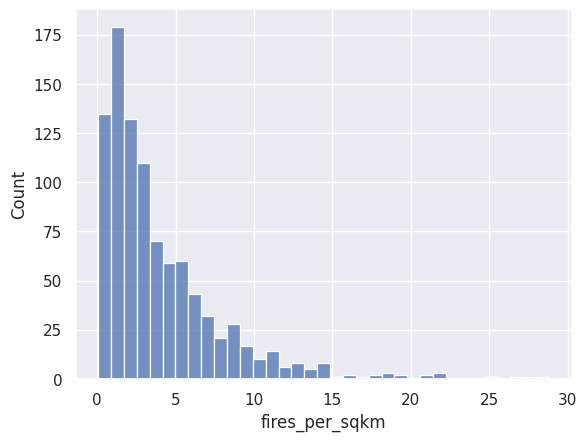

In [11]:
# Generating histogram of the response variable in order to set the cut-off threshold

pred_counts = df_final['pred'].value_counts().to_frame().reset_index().reindex(columns=['pred','index'])
pred_counts.rename(columns = {'pred':'count','index':'fires_per_sqkm'}, inplace = True)
pred_counts_nozero = pred_counts[1:]

sns.set()
sns.histplot(data=pred_counts_nozero, x=pred_counts_nozero['fires_per_sqkm'])

In [12]:
# Separating the response variable and converting it to binary high (1) or low (0) risk
# Splitting data into training and testing sets

thrsh_fires_sqkm = 8

df_final['pred_baseline'] = df_baseline['pred_baseline'].values

df_temp = df_final[df_final.index < pd.to_datetime('2021')]
X_train = df_temp.drop(['pred', 'pred_baseline'], axis=1)
y_train = pd.cut(df_temp['pred'], bins=[0,thrsh_fires_sqkm,99], labels=[0,1], include_lowest=True, right=False)
X_train_polyn = df_final_polyn[df_final_polyn.index < pd.to_datetime('2021')]

df_temp = df_final[(df_final.index >= pd.to_datetime('2021'))]
X_test = df_temp.drop(['pred', 'pred_baseline'], axis=1)
X_test_polyn = df_final_polyn[(df_final_polyn.index >= pd.to_datetime('2021'))]
y_test = pd.cut(df_temp['pred'], bins=[0,thrsh_fires_sqkm,99], labels=[0,1], include_lowest=True, right=False)
y_test_baseline = df_temp['pred_baseline']

print('X shape', df_final.shape, '\n')
print('X train', X_train.shape, '\n')
print('X test', X_test.shape, '\n')
print('test set ratio', X_test.shape[0]/(X_train.shape[0]+X_test.shape[0]))

X shape (43200, 37) 

X train (32940, 35) 

X test (10260, 35) 

test set ratio 0.2375


In [13]:
# Scaling data for models which gradient descent (i.e. Logistic Regression but not Random Forest)

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

scaler_polyn = MinMaxScaler()
scaler_polyn.fit(X_train_polyn)

X_train_polyn_s = scaler_polyn.transform(X_train_polyn)
X_test_polyn_s = scaler_polyn.transform(X_test_polyn)

MinMaxScaler()

MinMaxScaler()

In [14]:
# Undersampling of majority class

ran_state_1 = 1

undersample = RandomUnderSampler(sampling_strategy=0.25, random_state=ran_state_1)
X_under, y_under = undersample.fit_resample(X_train, y_train)
X_under_lr, y_under_lr = undersample.fit_resample(X_train_s, y_train)

undersample_polyn = RandomUnderSampler(sampling_strategy=0.25, random_state=ran_state_1)
X_under_polyn, y_under_polyn = undersample_polyn.fit_resample(X_train_polyn, y_train)
X_under_polyn_lr, y_under_polyn_lr = undersample_polyn.fit_resample(X_train_polyn_s, y_train)


print(len(X_under_polyn), '\n', sum(y_under_polyn))

1635 
 327


<AxesSubplot:xlabel='A_AvgYear_Condo', ylabel='A_AvgYear_Regulier'>

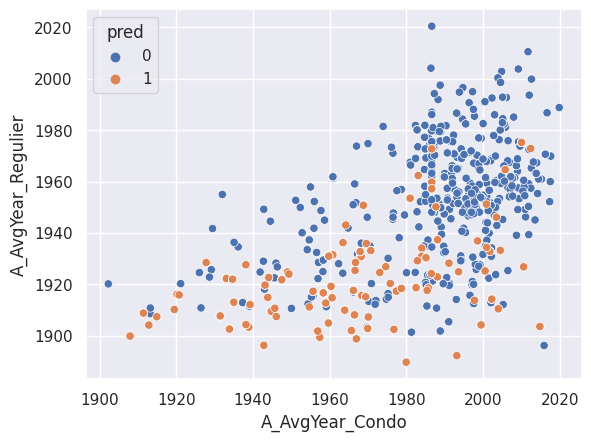

In [15]:
# Visual representation of the response variable imbalance (after undersampling)

sns.set()

X_plot = pd.DataFrame(X_under_polyn, columns=X_train_polyn.columns)
sns.scatterplot(x=X_plot['A_AvgYear_Condo'], y=X_plot['A_AvgYear_Regulier'], hue =y_under_polyn)

# Section 5 - Preliminary Feature Ranking
>Generated in order to use in the feature selection mechanism in the following section

In [16]:
# Preliminary feature ranking using a dummy RandomForest model

ran_state_2 = 1

#WITHOUT polynomial basis transformed features
reduc_upper = 30

RandForestClass_model = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=100, \
                                               min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, max_leaf_nodes=None, \
                                               min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=ran_state_2, \
                                               verbose=0, warm_start=False, class_weight='balanced', ccp_alpha=0.0, max_samples=None)
RandForestClass_model.fit(X_under, y_under)

feature_importance1 = pd.DataFrame(list(X_train.columns), index =list(RandForestClass_model.feature_importances_), columns =['Feature_Importance']).sort_index(ascending=False)
feature_importance1.head(5)

X_under_reduc = pd.DataFrame(X_under, columns=X_train.columns)
X_under_reduc = X_under_reduc[feature_importance1.Feature_Importance.iloc[0:reduc_upper]]

X_test_reduc = pd.DataFrame(X_test, columns=X_train.columns)
X_test_reduc = X_test_reduc[feature_importance1.Feature_Importance.iloc[0:reduc_upper]]

features_plot1 = feature_importance1.copy()
features_plot1['Importance'] = features_plot1.index
features_plot1 = features_plot1.set_index('Feature_Importance')

feat_std_plot1 = np.std([tree.feature_importances_ for tree in RandForestClass_model.estimators_], axis=0)


# #WITH polynomial basis tranformed features
# reduc_upper = 311

# RandForestClass_model = RandomForestClassifier(n_estimators=500, criterion='gini', max_depth=None, min_samples_split=100, min_samples_leaf=1, \
#                                                min_weight_fraction_leaf=0.0, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, \
#                                                bootstrap=True, oob_score=False, n_jobs=None, random_state=ran_state_2, verbose=0, warm_start=False, \
#                                                class_weight='balanced', ccp_alpha=0.0, max_samples=None)
# RandForestClass_model.fit(X_under_polyn, y_under_polyn)

# feature_importance2 = pd.DataFrame(list(X_train_polyn.columns), index =list(RandForestClass_model.feature_importances_), columns =['Feature_Importance']).sort_index(ascending=False)

# X_under_polyn_reduc = pd.DataFrame(X_under_polyn, columns=X_train_polyn.columns)
# X_under_polyn_reduc = X_under_polyn_reduc[feature_importance2.Feature_Importance.iloc[0:reduc_upper]]

# X_test_polyn_reduc = pd.DataFrame(X_test_polyn, columns=X_train_polyn.columns)
# X_test_polyn_reduc = X_test_polyn_reduc[feature_importance2.Feature_Importance.iloc[0:reduc_upper]]

# features_plot2 = feature_importance2.copy()
# features_plot2['Importance'] = features_plot2.index
# features_plot2 = features_plot2.set_index('Feature_Importance')

# feat_std_plot2 = np.std([tree.feature_importances_ for tree in RandForestClass_model.estimators_], axis=0)

RandomForestClassifier(class_weight='balanced', max_features=None,
                       min_samples_split=100, random_state=1)

,Feature_Importance
0.557264,B_PopDensity(sqkm)
0.136521,A_AvgYear_Regulier
0.051685,last_12months
0.041652,A_AvgYear_Condo
0.027508,A_Count_Coundo


<AxesSubplot:xlabel='Feature_Importance'>

Text(0.5, 1.0, 'Feature Importances')

Text(0.5, 0, 'Features')

Text(0, 0.5, 'Importance %')

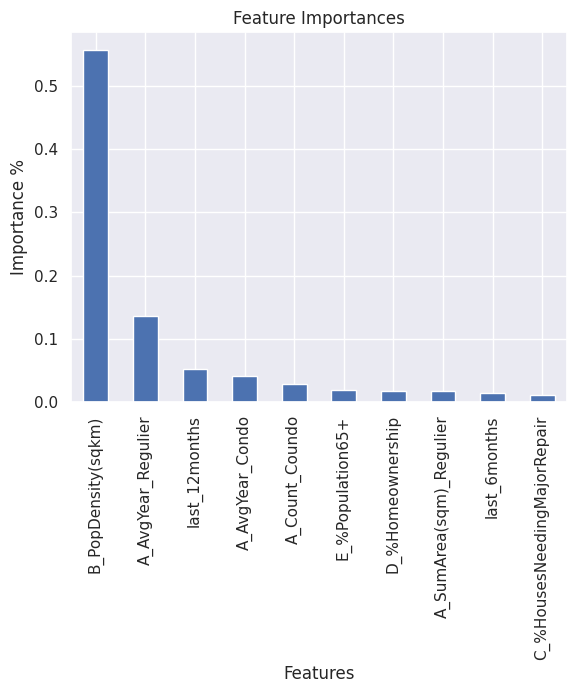

In [17]:
# Plot of the preliminary feature rankings

fig, ax = plt.subplots()

features_plot1.iloc[0:10].plot.bar(ax=ax)

ax.set_title("Feature Importances")
ax.set_xlabel("Features")
ax.set_ylabel("Importance %")
ax.get_legend().remove()

# Section 6 - Feature Selection and Hyperparamater Tuning

In [18]:
# Random Forest Hyperparameter Tuning using GridSearchCV
# The feature selection mechanism tests different cut-off values for the list of ranked features
# The best hypeparameter and cut-off values are stored for the final models

warnings.filterwarnings("ignore", category=FitFailedWarning)
warnings.filterwarnings("ignore", category=UserWarning)

mean_score = []
score_std_devs = []
num_params_ru = []
model_params = []

for reduc_upper in [1,2,3,4,5,6,7,8, 9, 10, 12, 14, 20, 30, 35]:

    X_under_reduc = pd.DataFrame(X_under, columns=X_train.columns)
    X_under_reduc = X_under_reduc[feature_importance1.Feature_Importance.iloc[0:reduc_upper]]

    X_test_reduc = pd.DataFrame(X_test, columns=X_train.columns)
    X_test_reduc = X_test_reduc[feature_importance1.Feature_Importance.iloc[0:reduc_upper]]
    
    ran_state_4 = 1

    RandForestClass_model = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=100, \
                                                   min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', \
                                                   max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, \
                                                   n_jobs=None, random_state=ran_state_4, verbose=0, warm_start=False, class_weight='balanced', \
                                                   ccp_alpha=0.0, max_samples=None)

    sqrt_no_features = int(math.sqrt(X_under_reduc.shape[1]))
    log_base2 = int(math.log(X_under_reduc.shape[1],2))
    dict_para ={'n_estimators': [5, 10, 15, 20, 25, 30, 40, 50, 100],
                'min_samples_split':[30, 40, 45, 50, 55, 60, 65, 70, 120],
                'max_features': [sqrt_no_features, 2, 3, 4, 5, 6, 7, 8, log_base2]}

    GS_CV = GridSearchCV(estimator = RandForestClass_model,
                       cv=None,
                       scoring='f1_weighted',
                       param_grid=dict_para)
    
    GS_CV.fit(X_under_reduc, y_under)

    results=pd.DataFrame(GS_CV.cv_results_)
    GS_CV.best_params_
  
    mean_score.append(results[results.loc[:, 'rank_test_score'] == 1]['mean_test_score'].values[0])
    score_std_devs.append(results[results.loc[:, 'rank_test_score'] == 1]['std_test_score'].values[0])
    num_params_ru.append(reduc_upper)
    model_params.append(results[results.loc[:, 'rank_test_score'] == 1]['params'].values[0])

top_scores = {'mean_score':mean_score, 'score_std_devs':score_std_devs, 'num_params_ru':num_params_ru, 'model_params':model_params}
model_params_dataframe = pd.DataFrame(data=top_scores)

model_params_dataframe['score_less_std'] = model_params_dataframe['mean_score'] - model_params_dataframe['score_std_devs']
model_params_dataframe_desc = model_params_dataframe.sort_values(by=['score_less_std'], ascending=False, ignore_index=True)
model_params_dataframe_desc[0:3]

# Best hyperparameters and features list cut-off values are stored
top_params_rf= model_params_dataframe_desc['model_params'][0]
reduc_upper_rf = model_params_dataframe_desc['num_params_ru'][0]

top_params_rf
reduc_upper_rf

GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced',
                                              max_features='sqrt',
                                              min_samples_split=100,
                                              random_state=1),
             param_grid={'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 0],
                         'min_samples_split': [30, 40, 45, 50, 55, 60, 65, 70,
                                               120],
                         'n_estimators': [5, 10, 15, 20, 25, 30, 40, 50, 100]},
             scoring='f1_weighted')

{'max_features': 1, 'min_samples_split': 45, 'n_estimators': 100}

GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced',
                                              max_features='sqrt',
                                              min_samples_split=100,
                                              random_state=1),
             param_grid={'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 1],
                         'min_samples_split': [30, 40, 45, 50, 55, 60, 65, 70,
                                               120],
                         'n_estimators': [5, 10, 15, 20, 25, 30, 40, 50, 100]},
             scoring='f1_weighted')

{'max_features': 2, 'min_samples_split': 45, 'n_estimators': 10}

GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced',
                                              max_features='sqrt',
                                              min_samples_split=100,
                                              random_state=1),
             param_grid={'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 1],
                         'min_samples_split': [30, 40, 45, 50, 55, 60, 65, 70,
                                               120],
                         'n_estimators': [5, 10, 15, 20, 25, 30, 40, 50, 100]},
             scoring='f1_weighted')

{'max_features': 1, 'min_samples_split': 40, 'n_estimators': 30}

GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced',
                                              max_features='sqrt',
                                              min_samples_split=100,
                                              random_state=1),
             param_grid={'max_features': [2, 2, 3, 4, 5, 6, 7, 8, 2],
                         'min_samples_split': [30, 40, 45, 50, 55, 60, 65, 70,
                                               120],
                         'n_estimators': [5, 10, 15, 20, 25, 30, 40, 50, 100]},
             scoring='f1_weighted')

{'max_features': 2, 'min_samples_split': 45, 'n_estimators': 10}

GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced',
                                              max_features='sqrt',
                                              min_samples_split=100,
                                              random_state=1),
             param_grid={'max_features': [2, 2, 3, 4, 5, 6, 7, 8, 2],
                         'min_samples_split': [30, 40, 45, 50, 55, 60, 65, 70,
                                               120],
                         'n_estimators': [5, 10, 15, 20, 25, 30, 40, 50, 100]},
             scoring='f1_weighted')

{'max_features': 2, 'min_samples_split': 70, 'n_estimators': 5}

GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced',
                                              max_features='sqrt',
                                              min_samples_split=100,
                                              random_state=1),
             param_grid={'max_features': [2, 2, 3, 4, 5, 6, 7, 8, 2],
                         'min_samples_split': [30, 40, 45, 50, 55, 60, 65, 70,
                                               120],
                         'n_estimators': [5, 10, 15, 20, 25, 30, 40, 50, 100]},
             scoring='f1_weighted')

{'max_features': 3, 'min_samples_split': 40, 'n_estimators': 5}

GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced',
                                              max_features='sqrt',
                                              min_samples_split=100,
                                              random_state=1),
             param_grid={'max_features': [2, 2, 3, 4, 5, 6, 7, 8, 2],
                         'min_samples_split': [30, 40, 45, 50, 55, 60, 65, 70,
                                               120],
                         'n_estimators': [5, 10, 15, 20, 25, 30, 40, 50, 100]},
             scoring='f1_weighted')

{'max_features': 6, 'min_samples_split': 65, 'n_estimators': 5}

GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced',
                                              max_features='sqrt',
                                              min_samples_split=100,
                                              random_state=1),
             param_grid={'max_features': [2, 2, 3, 4, 5, 6, 7, 8, 3],
                         'min_samples_split': [30, 40, 45, 50, 55, 60, 65, 70,
                                               120],
                         'n_estimators': [5, 10, 15, 20, 25, 30, 40, 50, 100]},
             scoring='f1_weighted')

{'max_features': 2, 'min_samples_split': 50, 'n_estimators': 40}

GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced',
                                              max_features='sqrt',
                                              min_samples_split=100,
                                              random_state=1),
             param_grid={'max_features': [3, 2, 3, 4, 5, 6, 7, 8, 3],
                         'min_samples_split': [30, 40, 45, 50, 55, 60, 65, 70,
                                               120],
                         'n_estimators': [5, 10, 15, 20, 25, 30, 40, 50, 100]},
             scoring='f1_weighted')

{'max_features': 4, 'min_samples_split': 45, 'n_estimators': 5}

GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced',
                                              max_features='sqrt',
                                              min_samples_split=100,
                                              random_state=1),
             param_grid={'max_features': [3, 2, 3, 4, 5, 6, 7, 8, 3],
                         'min_samples_split': [30, 40, 45, 50, 55, 60, 65, 70,
                                               120],
                         'n_estimators': [5, 10, 15, 20, 25, 30, 40, 50, 100]},
             scoring='f1_weighted')

{'max_features': 2, 'min_samples_split': 45, 'n_estimators': 20}

GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced',
                                              max_features='sqrt',
                                              min_samples_split=100,
                                              random_state=1),
             param_grid={'max_features': [3, 2, 3, 4, 5, 6, 7, 8, 3],
                         'min_samples_split': [30, 40, 45, 50, 55, 60, 65, 70,
                                               120],
                         'n_estimators': [5, 10, 15, 20, 25, 30, 40, 50, 100]},
             scoring='f1_weighted')

{'max_features': 2, 'min_samples_split': 120, 'n_estimators': 5}

GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced',
                                              max_features='sqrt',
                                              min_samples_split=100,
                                              random_state=1),
             param_grid={'max_features': [3, 2, 3, 4, 5, 6, 7, 8, 3],
                         'min_samples_split': [30, 40, 45, 50, 55, 60, 65, 70,
                                               120],
                         'n_estimators': [5, 10, 15, 20, 25, 30, 40, 50, 100]},
             scoring='f1_weighted')

{'max_features': 2, 'min_samples_split': 55, 'n_estimators': 15}

GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced',
                                              max_features='sqrt',
                                              min_samples_split=100,
                                              random_state=1),
             param_grid={'max_features': [4, 2, 3, 4, 5, 6, 7, 8, 4],
                         'min_samples_split': [30, 40, 45, 50, 55, 60, 65, 70,
                                               120],
                         'n_estimators': [5, 10, 15, 20, 25, 30, 40, 50, 100]},
             scoring='f1_weighted')

{'max_features': 2, 'min_samples_split': 70, 'n_estimators': 15}

GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced',
                                              max_features='sqrt',
                                              min_samples_split=100,
                                              random_state=1),
             param_grid={'max_features': [5, 2, 3, 4, 5, 6, 7, 8, 4],
                         'min_samples_split': [30, 40, 45, 50, 55, 60, 65, 70,
                                               120],
                         'n_estimators': [5, 10, 15, 20, 25, 30, 40, 50, 100]},
             scoring='f1_weighted')

{'max_features': 2, 'min_samples_split': 55, 'n_estimators': 10}

GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced',
                                              max_features='sqrt',
                                              min_samples_split=100,
                                              random_state=1),
             param_grid={'max_features': [5, 2, 3, 4, 5, 6, 7, 8, 5],
                         'min_samples_split': [30, 40, 45, 50, 55, 60, 65, 70,
                                               120],
                         'n_estimators': [5, 10, 15, 20, 25, 30, 40, 50, 100]},
             scoring='f1_weighted')

{'max_features': 2, 'min_samples_split': 120, 'n_estimators': 100}

,mean_score,score_std_devs,num_params_ru,model_params,score_less_std
0,0.805615,0.018705,6,"{'max_features': 3, 'min_samples_split': 40, '...",0.786910
1,0.813350,0.028135,30,"{'max_features': 2, 'min_samples_split': 55, '...",0.785215
2,0.804413,0.025993,35,"{'max_features': 2, 'min_samples_split': 120, ...",0.778420


{'max_features': 3, 'min_samples_split': 40, 'n_estimators': 5}

6

GridSearchCV(estimator=LogisticRegression(C=1, class_weight='balanced',
                                          penalty='l1', solver='liblinear'),
             param_grid={'C': [0.05, 0.1, 0.11, 0.125, 0.13, 0.15, 0.175, 0.2,
                               0.225, 0.24, 0.25, 0.26, 0.275, 0.3, 0.35, 0.4,
                               0.5, 0.6, 0.8, 1]},
             scoring='f1_weighted')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,0.019106,0.005658,0.003155,0.000122,0.125,{'C': 0.125},0.81483,0.777269,0.795857,0.842949,0.777379,0.801657,0.024885,1


{'C': 0.125}

<AxesSubplot:xlabel='param_C', ylabel='mean_test_score'>

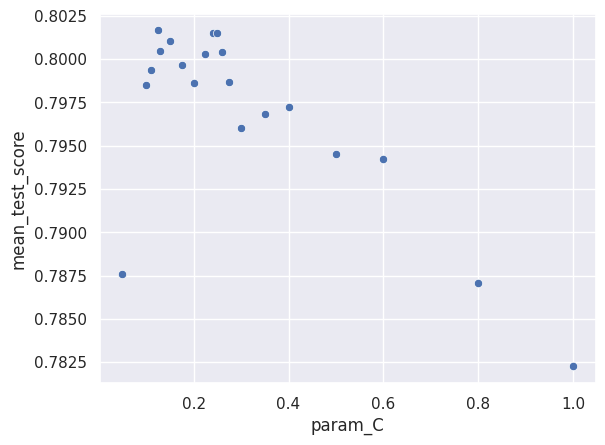

In [19]:
# Logistic Regression Hyperparameter Tuning using GridSearchCV
# The only hyperparamter is C, which represents the inverse regularization strength

LogistRegression_model = LogisticRegression(penalty='l1', C=1, solver = 'liblinear', class_weight='balanced')
    
dict_para ={'C': [0.05, 0.1, 0.11, 0.125, 0.13, 0.15, 0.175, 0.2, 0.225, 0.24, 0.25, 0.26, 0.275, 0.3, 0.35, 0.4, 0.5, 0.6, 0.8, 1]}

GS_CV_lr = GridSearchCV(estimator = LogistRegression_model,
                    cv=None,
                    scoring='f1_weighted',
                    param_grid=dict_para)
GS_CV_lr.fit(X_under_lr, y_under_lr)

results_lr=pd.DataFrame(GS_CV_lr.cv_results_)
results_lr[results_lr.loc[:, 'rank_test_score'] == 1]

# Best hyperparameters value is stored
top_params_lr = results_lr[results_lr.loc[:, 'rank_test_score'] == 1]['params'].values[0]

print('\n')
top_params_lr
print('\n')

# Plot of the model results at the different hyperparamter values
sns.set()
sns.scatterplot(x=results_lr['param_C'], y=results_lr['mean_test_score'])

# Section 7 - Final Models and Results
>Final results using test data [2021 to 07-2022]

In [20]:
# Random Forest Model

#The best hyperparamter and cut-off values are used
top_params = top_params_rf
reduc_upper = reduc_upper_rf

X_under_reduc = pd.DataFrame(X_under, columns=X_train.columns)
X_under_reduc = X_under_reduc[feature_importance1.Feature_Importance.iloc[0:reduc_upper]]

X_test_reduc = pd.DataFrame(X_test, columns=X_train.columns)
X_test_reduc = X_test_reduc[feature_importance1.Feature_Importance.iloc[0:reduc_upper]]

#Final model trained
RandForestClass_model = RandomForestClassifier(n_estimators=top_params['n_estimators'], criterion='gini', \
                                               max_depth=None, min_samples_split=top_params['min_samples_split'], \
                                               min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=top_params['max_features'], \
                                               max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, \
                                               n_jobs=None, random_state=ran_state_4, verbose=0, warm_start=False, class_weight='balanced', \
                                               ccp_alpha=0.0, max_samples=None)
RandForestClass_model.fit(X_under_reduc, y_under)

#Results used to generate metrics
y_pred = RandForestClass_model.predict(X_test_reduc)
conf_mat = confusion_matrix(y_test, y_pred)
TPR = conf_mat[1,1]/(conf_mat[1,1]+conf_mat[1,0])
FPR = conf_mat[0,1]/(conf_mat[0,1]+conf_mat[0,0])
f1 = f1_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
print('\n', 'Random Forest Model Confusion Matrix:', '\n', conf_mat,  '\n\n', '{:.1%}'.format(TPR), '*True Positive Rate*', '\n', \
      '{:.1%}'.format(FPR), '*False Positive Rate*', '\n', '{:.1%}'.format(balanced_accuracy),'*Balanced Accuracy*')

fpr_rf, tpr_rf, _ = roc_curve(y_test, RandForestClass_model.predict_proba(X_test_reduc)[:,1], pos_label=1)

RandomForestClassifier(class_weight='balanced', max_features=3,
                       min_samples_split=40, n_estimators=5, random_state=1)


 Random Forest Model Confusion Matrix: 
 [[8317 1850]
 [  12   81]] 

 87.1% *True Positive Rate* 
 18.2% *False Positive Rate* 
 84.5% *Balanced Accuracy*


In [21]:
#Logistic Regression Model

#The best hyperparamter is used
top_params = top_params_lr

#Final model trained
LogistRegression_model = LogisticRegression(penalty='l1', C=top_params['C'], solver = 'liblinear', class_weight='balanced')
LogistRegression_model.fit(X_under_lr, y_under_lr)

#Results used to generate metrics
y_pred = LogistRegression_model.predict(X_test_s)
conf_mat = confusion_matrix(y_test, y_pred)
TPR = conf_mat[1,1]/(conf_mat[1,1]+conf_mat[1,0])
FPR = conf_mat[0,1]/(conf_mat[0,1]+conf_mat[0,0])
f1 = f1_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
print('\n', 'Logistic Regression Model Confusion Matrix:', '\n', conf_mat,  '\n\n', '{:.1%}'.format(TPR), '*True Positive Rate*', '\n', \
      '{:.1%}'.format(FPR), '*False Positive Rate*', '\n', '{:.1%}'.format(balanced_accuracy),'*Balanced Accuracy*')

fpr_lr, tpr_lr, _ = roc_curve(y_test, LogistRegression_model.predict_proba(X_test_s)[:,1], pos_label=1)

LogisticRegression(C=0.125, class_weight='balanced', penalty='l1',
                   solver='liblinear')


 Logistic Regression Model Confusion Matrix: 
 [[7869 2298]
 [  15   78]] 

 83.9% *True Positive Rate* 
 22.6% *False Positive Rate* 
 80.6% *Balanced Accuracy*


In [22]:
#Baseline Model

y_pred = df_baseline['pred_baseline'].loc[(df_baseline.index >= pd.to_datetime('2021'))]

conf_mat = confusion_matrix(y_test, y_pred)
TPR = conf_mat[1,1]/(conf_mat[1,1]+conf_mat[1,0])
FPR = conf_mat[0,1]/(conf_mat[0,1]+conf_mat[0,0])
f1 = f1_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
print('Baseline Model Confusion Matrix:', '\n', conf_mat,  '\n\n', '{:.1%}'.format(TPR), '*True Positive Rate*', '\n', \
      '{:.1%}'.format(FPR), '*False Positive Rate*', '\n', '{:.1%}'.format(balanced_accuracy),'*Balanced Accuracy*')

y_baseline = df_baseline.loc[(df_baseline.index >= pd.to_datetime('2021')) , ['monthly_mean']]['monthly_mean']/df_baseline.loc[(df_baseline.index >= pd.to_datetime('2021')) , ['monthly_mean']]['monthly_mean'].max()
fpr_baseline, tpr_baseline, th = roc_curve(y_test, y_baseline, pos_label=1, drop_intermediate=True)

Baseline Model Confusion Matrix: 
 [[7454 2713]
 [  33   60]] 

 64.5% *True Positive Rate* 
 26.7% *False Positive Rate* 
 68.9% *Balanced Accuracy*


In [23]:
# Exporting model predictions to drive as CSV file

#Filtering dates corresponding to test set
df_w_DGUID = df_w_DGUID[(df_w_DGUID.index >= pd.to_datetime('2021'))]

#Adding baseline model predictions
df_w_DGUID[['baseline_model_mean', 'baseline_model_pred']] = df_baseline.loc[(df_baseline.index >= pd.to_datetime('2021')), ['monthly_mean', 'pred_baseline']].copy()

#Adding Random Forest and Logistic Regression model predictions
RF_model_pred = pd.DataFrame(RandForestClass_model.predict(X_test_reduc), index =df_w_DGUID.index, columns = ['RF_model_pred'])
LR_model_pred = pd.DataFrame(LogistRegression_model.predict(X_test_s), index =df_w_DGUID.index, columns = ['LR_model_pred'])

df_w_DGUID['RF_model_pred'] = RF_model_pred
df_w_DGUID['LR_model_pred'] = LR_model_pred

#Exporting dataframe to CSV file
df_w_DGUID.to_csv('df_final_models_pred.csv')

(0.0, 1.01)

(0.0, 1.02)

Text(0.5, 1.0, 'ROC Curves')

Text(0.5, 0, 'FPR')

Text(0, 0.5, 'TPR')

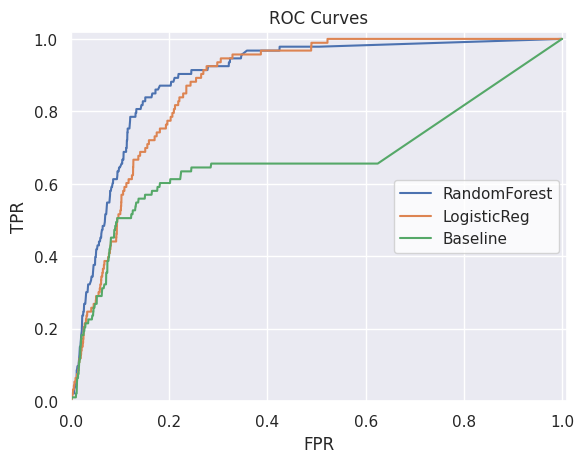

In [24]:
# Visual comparison of the ROC curves for the final models and the baseline model

fig, ax = plt.subplots()
sns.set(rc={'axes.facecolor':'white', 'axes.edgecolor': 'black'})

plt.xlim(0, 1.01)
plt.ylim(0, 1.02)

plt.plot(fpr_rf, tpr_rf, label='RandomForest')
plt.plot(fpr_lr, tpr_lr, label='LogisticReg')
plt.plot(fpr_baseline, tpr_baseline, label='Baseline')

ax.set_title("ROC Curves")
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.legend(loc='center right')